## 2. *Question Answering*

Las redes neuronales recurrentes hoy en día han sido aplicadas a varios problemas que involucra dependencia temporal de los datos de entrada, en textos por lo común, tal como los modelos *sequence to sequence* de traducción, resumir textos, formular hipótesis de un extracto o, como veremos en esta actividad, generar respuesta en base a alguna pregunta. En imágenes también han sido aplicadas, ya sea a procesamiento de videos u a otro problema en que las imágenes tienen dependencia temporal unas con otras.

Para ésta actividad trabajaremos el dataset de __[SQuAD2.0](https://rajpurkar.github.io/SQuAD-explorer/)__  (The Stanford Question Answering Dataset), los datos se los entregamos en formato *csv*, sin ningún preprocesamiento, para que sea mas fácil la lectura. La tarea como ya se comentó consiste en predecir una respuesta (secuencia de palabras) que contesten una pregunta también en forma de secuencia de palabras, con un enfoque *encoder-decoder* con módulos de antención.


<img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2017/07/20/sockeye_1.gif" title="Attention" width="65%" style="float: right;"/>


<img src="http://www.wildml.com/wp-content/uploads/2015/12/Screen-Shot-2015-12-30-at-1.16.08-PM.png" title="Attention" width="35%" style="float: left;"/>



Los módulos de antención [[6]](#refs) son una variación a la arquitectura *encoder-decoder* en donde se agrega que para cada instante de tiempo de la **decodificación** $T'$ hay una combinación lineal del vector de codificación en todos los instantes tiempo $T$, ésto es para que en cada instante de tiempo de la decodificación se ponga atención a cierta información en toda la secuencia de entrada. 


$$
y_{T'} = \sum_{t}^{T} \alpha_{T',t} \cdot h_t^{codificacion}
$$


In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize

> a) Carge los datos y descríbalos ¿Cuántos ejemplos se tienen para entrenar y para predecir?

Previo a la carga de los datos debemos sabes más información de dónde provenienen y qué son. Stanford Question Answering Dataset (SQuAD) es un conjunto de datos de comprensión de lectura, que consiste en preguntas formuladas por [crowdworkers](https://es.wikipedia.org/wiki/Crowdsourcing) sobre un conjunto de artículos de Wikipedia, donde la respuesta a cada pregunta es un segmento de texto, o span, del pasaje de lectura correspondiente. Además, dada la naturaleza de las preguntas estás podrían ser incontestables. 

Este dataset busca probar a los sistemas inteligentes no solamente para responder preguntas de comprensión lectora, sino que busca que los sistemas puedan identificar cuándo una pregunta no puede ser respondida.


Dicho esto, primero cargamos los datos. Éstos vienen separados en dos datasets, uno para training y otro para testing. 

In [2]:
#df_train = pd.read_csv('drive/Colab-Notebooks/train_Q-A.csv')
df_train = pd.read_csv('train_Q-A.csv')
df_train.dropna(inplace=True)
#df_test = pd.read_csv('drive/Colab-Notebooks/test_Q.csv')
df_test = pd.read_csv('test_Q.csv')
df_train.head()

,id,question,answer
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,in the late 1990s
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,singing and dancing
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,2003
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,late 1990s


El conjunto de datos de entrenamiento contiene tres columnas: id, **question** y **answer**. Cada entra en el dataset contiene una pregunta en conjunto con su respuesta. Estas están escritas en inglés, y por lo que se puede ver continen letras, números y caracteres de puntuación.

In [3]:
print("Cantidad de ejemplos de entrenamiento: ", df_train.shape[0])
print("Cantidad de ejemplos de prueba: ", df_test.shape[0])

Cantidad de ejemplos de entrenamiento:  86821
Cantidad de ejemplos de prueba:  11873


La cantidad de datos de entrenamiento es 86.821 y los datos de prueba son 11.873.

In [4]:
df_train.describe()

,id,question,answer
count,86821,86821,86821
unique,86821,86769,64763
top,56f901629e9bad19000a07b7,When did Nasser die?,three
freq,1,2,231


Se puede ver que hay tanto preguntas como respuestas repetidas, con una mayor cantida de respuestas repetidas.. Debido a que algunas de estas son cortas (dos palabras) es probable que se repitan en más de una ocación. 

In [5]:
df_test.describe()

,id,question
count,11873,11873
unique,11873,11864
top,57280f974b864d1900164374,Where does heat rejection occur in the Rankine...
freq,1,2


> b) Realice un preprocesamiento simple a los textos de entrada (preguntas) *tokenizandolos* y pasando a minúsculas para evitar ambiguedad, si desea agregar algun preprocesamiento éxtra ésto se verá reflajado en su nota. A los textos de salida (respuestas) no realice ningún preprocesamiento mas que *tokenizar*, puesto que para la evaluación se solicita retornar los textos en su forma natural. Comente lo realizado.

Se hace un preprocesamiento de dos partes. En la primera se pasarán las preguntas a minúsculas y luego se *tokenizarán*. Cabe destacar que la *tokenización* utilizada elimina los signos de interrogación y de puntuación, no eliminando los números que aportan información tanto en preguntas como en respuestas.


In [6]:
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

#preprocesamiento textos de entrada
train_questions = [tokenizer.tokenize(sentence.lower()) for sentence in df_train["question"]]
test_questions = [tokenizer.tokenize(sentence.lower()) for sentence in df_test["question"]]

[nltk_data] Downloading package punkt to /home/nacho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
print(train_questions[7])

['who', 'managed', 'the', 'destiny', 's', 'child', 'group']


In [8]:
df_train["question"][:10]

0             When did Beyonce start becoming popular?
1    What areas did Beyonce compete in when she was...
2    When did Beyonce leave Destiny's Child and bec...
3        In what city and state did Beyonce  grow up? 
4           In which decade did Beyonce become famous?
5           In what R&B group was she the lead singer?
6        What album made her a worldwide known artist?
7               Who managed the Destiny's Child group?
8                       When did Beyoncé rise to fame?
9       What role did Beyoncé have in Destiny's Child?
Name: question, dtype: object

De igual manera se *tokenizan* las palabras de las respuestas.

In [10]:
train_answers = [word_tokenize(sentence) for sentence in df_train["answer"]]

La segunda parte del procesamiento consiste en realizar lemmatización a las preguntas. Esto hará que las palabras sean reemplazadas por su raiz léxica actuando como normalizador de los datos de entrada. Así se podrá reducir el vocabulario y se evitará tener muchas palabras con el mismo significado, pero diferente forma (como pasa con las conjugaciones de los verbos)

In [11]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# lemmas para train y test
for q in range(len(train_questions)):
    train_questions[q] = [WordNetLemmatizer().lemmatize(w) for w in train_questions[q]]
for q in range(len(test_questions)):
    test_questions[q] = [WordNetLemmatizer().lemmatize(w) for w in test_questions[q]]

[nltk_data] Downloading package wordnet to /home/nacho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
train_questions[3:9]

[['in', 'what', 'city', 'and', 'state', 'did', 'beyonce', 'grow', 'up'],
 ['in', 'which', 'decade', 'did', 'beyonce', 'become', 'famous'],
 ['in', 'what', 'r', 'b', 'group', 'wa', 'she', 'the', 'lead', 'singer'],
 ['what', 'album', 'made', 'her', 'a', 'worldwide', 'known', 'artist'],
 ['who', 'managed', 'the', 'destiny', 's', 'child', 'group'],
 ['when', 'did', 'beyoncé', 'rise', 'to', 'fame']]

In [13]:
len_questions = [len(q) for q in train_questions]
len_answers = [len(a) for a in train_answers]
len_q_test = [len(tq) for tq in test_questions]

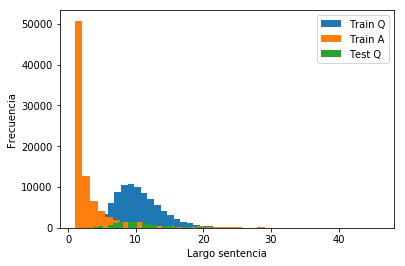

In [14]:
%matplotlib inline  
import matplotlib.pyplot as plt
plt.hist(len_questions, bins=40, label="Train Q")
plt.hist(len_answers,bins=40, label="Train A")
plt.hist(len_q_test,bins=40, label="Test Q")
plt.xlabel("Largo sentencia")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

En general las preguntas tienen un largo reducido siendo la gran cantidad de ellas con largo menor a 10. Más adelante retomaremos el análisis de largo de sentencias.

> c) Cree un vocabulario para codificar las palabras en las respuestas a generar. Repita el procedimiento para las preguntas. Agrege un símbolo que signifique el fin de la respuesta a generar, así para tener un criterio de cuando una respuesta, valga la redundancia, está efectivamente *respondida* ¿Cuántas palabras tiene el vocabulario de las respuestas y de las preguntas? ¿Ésto podría ser un problema al momento de entrenar la red para que predizca de entre todas ellas?


Se generarán dos clases de diccionarios: uno que utiliza las palabras como *keys* y los id como *values*, y otro que es el inverso a este.


In [15]:
v_a = {}
vocab_answer = set()
for sentence in train_answers:
    for word in sentence:
        vocab_answer.add(word)
        if word not in v_a:
            v_a[word] = 0
        v_a[word] +=1
    
vocab_answer = ["#end"]+ list(vocab_answer)
print('posibles palabras para respuestas :', len(vocab_answer))
vocabA_indices = {c: i for i, c in enumerate(vocab_answer)}
indices_vocabA = {i: c for i, c in enumerate(vocab_answer)}

posibles palabras para respuestas : 47423


El tamaño total del vocabulario de las respuestas es de 47.423 términos.

In [16]:
v_q = {}
vocab_question = set()
for sentence in train_questions+test_questions:
    for word in sentence:
        vocab_question.add(word)
        if word not in v_q:
            v_q[word] = 0
        v_q[word] +=1        
vocab_question = list(vocab_question)
print('posibles palabras para preguntas :', len(vocab_question))
vocabQ_indices = {c: i for i, c in enumerate(vocab_question)}


posibles palabras para preguntas : 34758


El tamaño de posibles palabras para preguntas es de 35.201. Dada la cantidad de palabras es interesando analizar cuántas veces se repite cada una y la distribución de estas.

Para las preguntas.

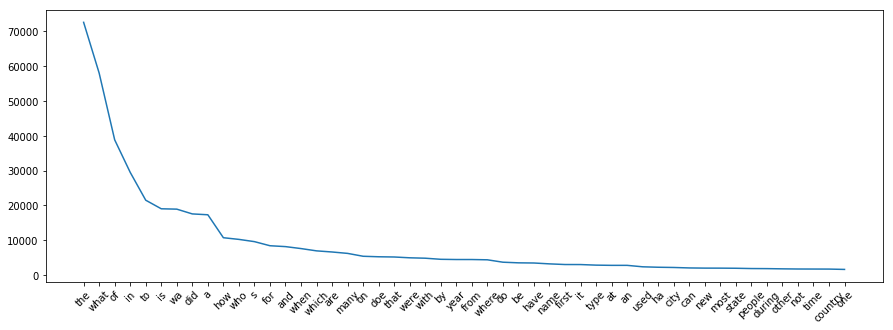

In [17]:
aux = [(w, v_q[w]) for w in sorted(v_q, key=v_q.get, reverse=True)][:50]
plt.figure(figsize=(15,5))
plt.plot([w[0] for w in aux], [w[1] for w in aux])
plt.xticks(rotation=45)
plt.show()

Para respuestas.

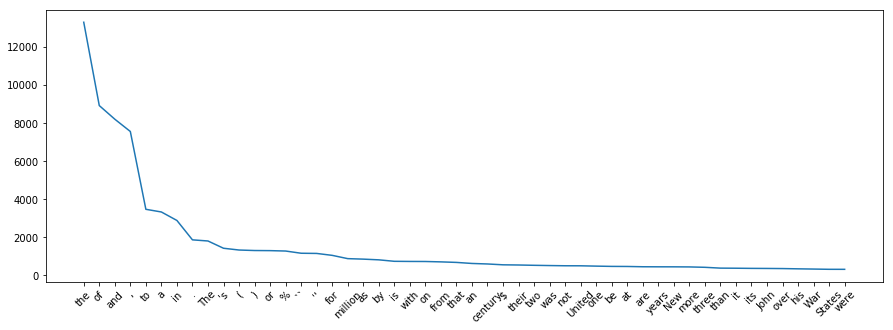

In [18]:
aux = [(w, v_a[w]) for w in sorted(v_a, key=v_a.get, reverse=True)][:50]
plt.figure(figsize=(15,5))
plt.plot([w[0] for w in aux], [w[1] for w in aux])
plt.xticks(rotation=45)
plt.show()

Para ambos set las palabras que más se repiten son stopwords pero son importantes. Al eliminar todas el entrenamiento final sería solamente con 8000 palabras aproximadamente, lo que hace perder el contexto en la mayoría de los casos.

> d) Codifique los tokens (palabras) de cada texto que utilizará.

Utilizando los diccionarios en base a los índices del punto anterior, se cambia cada token por su id correspondiente. Este procedimiento se aplica para preguntas y respuesta de testing y training.

In [19]:
#input and output to onehotvector
X_answers = [[vocabA_indices[palabra] for palabra in sentence] for sentence in train_answers]
Xtrain_question = [[vocabQ_indices[word] for word in sentence] for sentence in train_questions]
Xtest_question = [[vocabQ_indices[word] for word in sentence] for sentence in test_questions]

Así, quedaremos con 86.821 documentos de entrenamiento y 11.873 de prueba.

In [20]:
print(len(Xtrain_question))
len(Xtest_question)

86821


11873

> Luego de ésto realice un padding a ambas secuencias, entrada y salida de entrenamiento y a la entrada del conjunto de pruebas. Comente sobre las dimensionalidades finales de los conjuntos de entrenamiento y de prueba.

Por limitaciones de la implementación es necesario realizar un padding a las sentencias. Dado que los largos máximos para preguntas y respuestas son 40 y 47 respectivamente, se completará con un valor $0$ para hacer que todas las preguntas tengas igual dimensión. En el caso de las preguntas se necesita saber en que momento se resuelve la consulta por lo que se agrega un caracter diferente que indica que la pregunta ha sido respondida. Se elige utilizar un padding post sentencia dado los buenos resultados que generó en la tarea anterior. Nuestro supuesto es que ayuda en la construcción de respuestas hacer este proceso después de la sentencia que antes. 

In [21]:
import numpy as np
max_input_lenght = np.max(list(map(len,train_questions)))
max_output_lenght = np.max(list(map(len,train_answers)))+1
print("Max largo pregunta: {}\nMax largo respuesta: {}".format(max_input_lenght, max_output_lenght))

from keras.preprocessing import sequence
Xtrain_question = sequence.pad_sequences(Xtrain_question,maxlen=max_input_lenght,padding='post',value=0)
Xtest_question = sequence.pad_sequences(Xtest_question,maxlen=max_input_lenght,padding='post',value=0)
X_answers = sequence.pad_sequences(X_answers,maxlen=max_output_lenght,padding='post',value=vocabA_indices["#end"])

Max largo pregunta: 40
Max largo respuesta: 47


Using TensorFlow backend.


In [22]:
print("Dimensiones Xtrain: {}".format(Xtrain_question.shape))
print("Dimensiones Xtest: {}".format(Xtest_question.shape))
print("Dimensiones Output: {}".format(X_answers.shape))

Dimensiones Xtrain: (86821, 40)
Dimensiones Xtest: (11873, 40)
Dimensiones Output: (86821, 47)


Las dimensiones finales son (86.821, 40) para los datos de entrenamiento, (11.873, 40) para los datos de testing, y (86.821, 47) para las salidas de la red.

In [23]:
X_answers  = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
print("Nueva dimensión salida: {}".format(X_answers.shape))

Nueva dimensión salida: (86821, 47, 1)


> e) Defina el modelo encoder-decoder con los módulos de atención.

Se trabajará con 3 modelos de encoder-decoder: CuDNNLSTM, LSTM y Bidirectional.

In [24]:
#Encoder-Decoder modelo
from keras.layers import Input,RepeatVector,TimeDistributed,Dense,Embedding,Flatten,Activation,Permute,Lambda, CuDNNLSTM, LSTM,CuDNNGRU
from keras.models import Model
from keras import backend as K
lenght_output = max_output_lenght
hidden_dim = 128

> Defina el encoder y las compuertas que utilizará: CuDNNGRU,CuDNNLSTM, RNN u otra. Puede utilizar redes bidireccionales en el encoder ¿Esto mejora el resultado?

El primer modelo será CuDNNGRU.

In [25]:
embedding_vector = 64 
encoder_input = Input(shape=(max_input_lenght,))
embedded = Embedding(input_dim=len(vocabQ_indices)+1,output_dim = embedding_vector,input_length=max_input_lenght)(encoder_input)
encoder = CuDNNGRU(hidden_dim, return_sequences=True)(embedded)

In [26]:
max_output_lenght

47

>Defina la atención $\alpha$ que se calculará sobre cada instante de tiempo $T$ computándo su atención en cada instante de tiempo de la decodificación $T'$.

In [27]:
# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder)
#softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)

Aplique la atención sobre el encoder y genere las salidas correspondientes.

In [28]:
# apply the attention to encoder
def attention_multiply(vects):
    encoder, attention = vects
    return K.batch_dot(attention,encoder, axes=1)
sent_representation = Lambda(attention_multiply)([encoder, attention])

decoder = CuDNNGRU(hidden_dim, return_sequences=True)(sent_representation)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder)

Defina el modelo y descríbalo adecuadamente.

In [29]:
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 64)       2224576     input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 40, 128)      74496       embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 40, 47)       6063        cu_dnngru_1[0][0]                
__________________________________________________________________________________________________
permute_1 

In [35]:
!pip install pydot

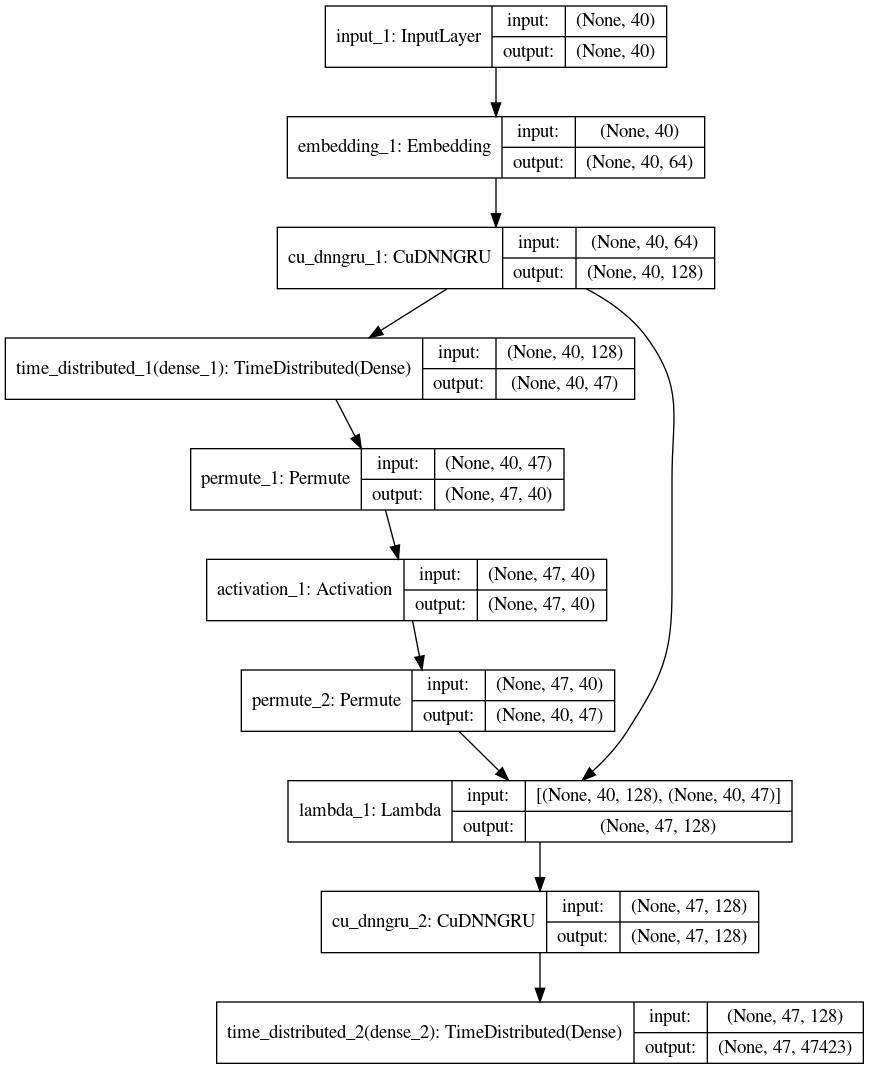

In [30]:
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model, to_file='model_p2.png', show_shapes=True)
Image(filename='model_p2.png')

f) Entrene el modelo por 10 epochs con el tamaño de batch que estime conveniente. Para ésto deberá redimensionar la salida para que tenga 3 dimensiones debido a la recurrencia.

In [26]:
#X_answers = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
#X_answers.shape
model.fit(Xtrain_question,X_answers,epochs=10,batch_size=128,validation_split=0.2)

Train on 69456 samples, validate on 17365 samples
Epoch 1/10
69456/69456 [==============================] - 355s 5ms/step - loss: 1.2216 - val_loss: 0.7922
Epoch 2/10
69456/69456 [==============================] - 353s 5ms/step - loss: 0.6964 - val_loss: 0.8001
Epoch 3/10
69456/69456 [==============================] - 352s 5ms/step - loss: 0.6830 - val_loss: 0.8074
Epoch 4/10
69456/69456 [==============================] - 352s 5ms/step - loss: 0.6744 - val_loss: 0.8088
Epoch 5/10
69456/69456 [==============================] - 351s 5ms/step - loss: 0.6655 - val_loss: 0.8113
Epoch 6/10
69456/69456 [==============================] - 351s 5ms/step - loss: 0.6563 - val_loss: 0.8180
Epoch 7/10
69456/69456 [==============================] - 351s 5ms/step - loss: 0.6480 - val_loss: 0.8328
Epoch 8/10
69456/69456 [==============================] - 351s 5ms/step - loss: 0.6400 - val_loss: 0.8295
Epoch 9/10
69456/69456 [==============================] - 351s 5ms/step - loss: 0.6316 - val_loss: 0.8

In [0]:
model.save("QA.h5")

In [51]:
#from google.colab import files
#files.download( "QA.h5" ) 
!ls

QA.h5  sample_data


In [0]:
model.save("drive/QA.h5")

In [0]:
from keras.models import load_model
model = load_model('drive/QA.h5')

> g) Muestre ejemplos de la predicción del modelo, para ésto genere una función que prediga a través de la distribución de probabilidad de la salida, de la forma que estime conveniente, cada palabra en cada instante de tiempo.


La función de predicción descrita genera un conjunto de datos aleatoriamente seleccionado entre los ejemplos entregados.

In [ ]:
import random

def predict_words(model,example,diversity):
    question = list()
    y_pred = model.predict(np.asarray([example]))
    for words in y_pred[0]:
        question.append(random.choice(np.argpartition(words,diversity)[diversity:]))
    return question

In [64]:
n = 10
for i in range(n):
    indexs = np.random.randint(0,len(Xtest_question))
    example = Xtest_question[indexs]
    indexes_answer = predict_words(model,example,5)
    question = df_test["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index] == "#end": # el final de la oracion
            continue
        else:
            answer += indices_vocabA[index]+" "
    print("Respuesta: ", answer)
print("Los ha predecido todos!")


Pregunta:  How many societal class divisions were in the plan Kublai rejected?
Respuesta:  Haven-style 12-month 867 867 867 Geertz Geertz Zune Geertz Zune Zune 867 calamine Geertz Zune Geertz calamine calamine Geertz Zune calamine Geertz 867 Desperately 867 867 Geertz Geertz Geertz 867 Geertz Desperately 867 867 
Pregunta:  What does TFEU article 288 not say?
Respuesta:  Zune Square 867 Geertz Geertz Zune Zune Geertz Zune Zune Geertz Zune calamine Zune Geertz Geertz Zune Geertz Geertz Zune calamine calamine Zune calamine Geertz 867 867 Zune calamine calamine Zune calamine calamine Geertz Geertz Zune Zune 
Pregunta:  Stephen Eildmann cites the oldest known example of civil disobedience in what part of the bible? 
Respuesta:  whorls 12-month calamine calamine Geertz 867 Geertz calamine Geertz Geertz Geertz calamine Geertz Zune Geertz Geertz calamine Geertz calamine Zune Geertz Zune Geertz Zune calamine calamine Geertz 867 calamine 867 Zune 867 Zune Zune Geertz calamine Zune 867 Zune 
Pre

Ṕara la primera red entrenada las respuestas tienden a tener el mismo largo y a tener las mismas palabras, siendo respuestas sin sentido. Es extraño este caso cuando la mayor parte de las respuestas del dataset de entrenamiento eran de un largo pequeño.

> h) Evalúe la calidad de su modelo con la métrica del benchmark, para ésto deberá descargar el archivo evaluation script y el dato dev json de la página oficial del dataset: https://rajpurkar.github.io/SQuAD-explorer/ y ejecutarlo de la siguiente manera dentro del Jupyter Notebook



In [67]:
import json

contador = 1
dic_predictions = {}
for example,id_e in zip(Xtest_question,df_test["id"]): #todos los ejemplos
    indexes_answer = predict_words(model,example) #predice palabra en cada instante
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    dic_predictions[id_e] = answer
    contador+=1
print("Los ha predecido todos!")
json_save = json.dumps(dic_predictions)
archivo = open("predictions","w")
archivo.write(json_save)
archivo.close()

Los ha predecido todos!


In [68]:
#evaluar resultados
!python evaluate-v2.0.py dev-v2.0.json predictions

{
  "exact": 0.0,
  "f1": 0.0011669235035224271,
  "total": 11873,
  "HasAns_exact": 0.0,
  "HasAns_f1": 0.002337193447591393,
  "HasAns_total": 5928,
  "NoAns_exact": 0.0,
  "NoAns_f1": 0.0,
  "NoAns_total": 5945
}


Evaluando con el script presente en la página del dataset descrubrimos que este modelo tiene un bajo rendimiento, en comparación al puntaje humano y al mayor puntaje presentado por papers.

Ahora se probará con una LSTM.

In [31]:
# probar con otras compuertas
embedding_vector = 64 
encoder_input = Input(shape=(max_input_lenght,))
embedded = Embedding(input_dim=len(vocabQ_indices)+1,output_dim = embedding_vector,input_length=max_input_lenght)(encoder_input)
encoder_lstm = LSTM(hidden_dim, return_sequences=True)(embedded)

# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder_lstm)
#softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)

sent_representation = Lambda(attention_multiply)([encoder_lstm, attention])

decoder_lstm = LSTM(hidden_dim, return_sequences=True)(sent_representation)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder_lstm)
###
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 64)       2224576     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 40, 128)      98816       embedding_2[0][0]                
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 40, 47)       6063        lstm_1[0][0]                     
__________________________________________________________________________________________________
permute_3 

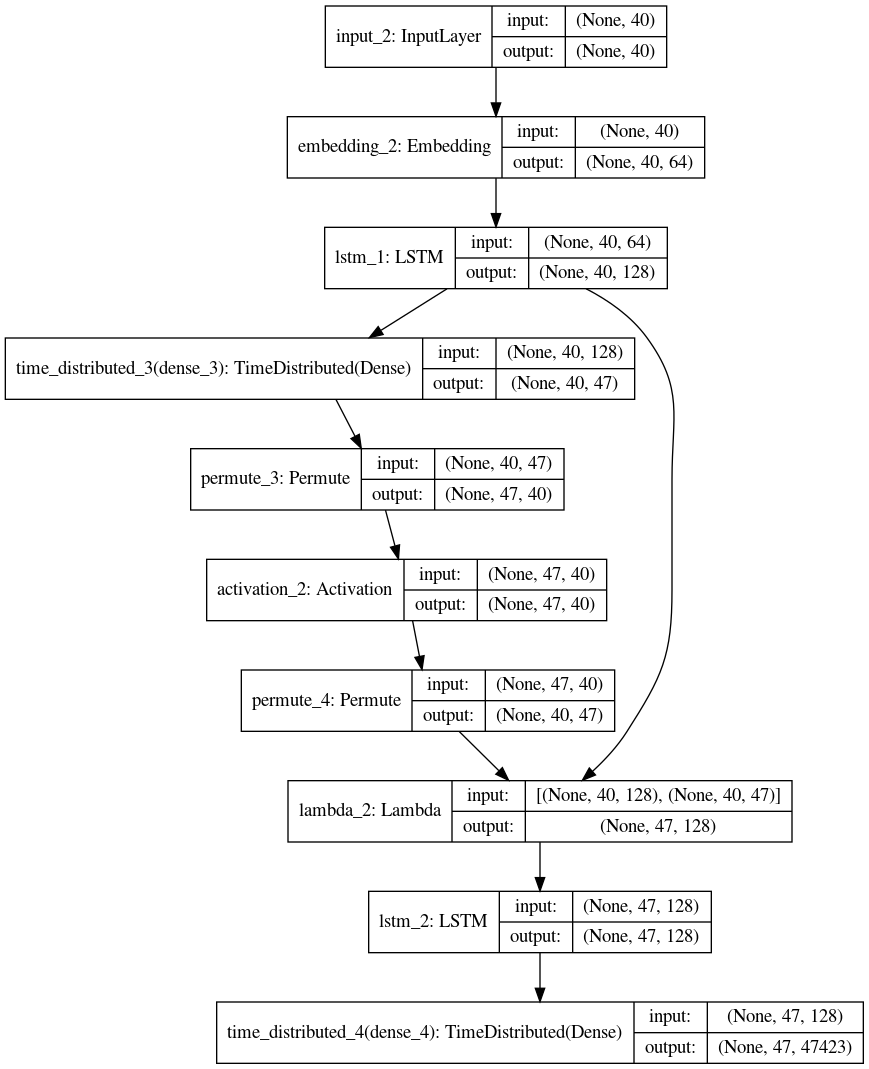

In [32]:
plot_model(model, to_file='model_p2.png', show_shapes=True)
Image(filename='model_p2.png')

Se entrena el nuevo modelo.

In [74]:
model.fit(Xtrain_question,X_answers,epochs=10,batch_size=128,validation_split=0.2)
model.save("drive/QA-LSTM.h5")

Train on 69456 samples, validate on 17365 samples
Epoch 1/10
69456/69456 [==============================] - 434s 6ms/step - loss: 1.3063 - val_loss: 0.8003
Epoch 2/10
69456/69456 [==============================] - 433s 6ms/step - loss: 0.7026 - val_loss: 0.7983
Epoch 3/10
69456/69456 [==============================] - 433s 6ms/step - loss: 0.6876 - val_loss: 0.8059
Epoch 4/10
69456/69456 [==============================] - 433s 6ms/step - loss: 0.6761 - val_loss: 0.8117
Epoch 5/10
69456/69456 [==============================] - 433s 6ms/step - loss: 0.6661 - val_loss: 0.8176
Epoch 6/10
69456/69456 [==============================] - 433s 6ms/step - loss: 0.6575 - val_loss: 0.8253
Epoch 7/10
69456/69456 [==============================] - 433s 6ms/step - loss: 0.6508 - val_loss: 0.8293
Epoch 8/10
69456/69456 [==============================] - 433s 6ms/step - loss: 0.6442 - val_loss: 0.8375
Epoch 9/10
69456/69456 [==============================] - 433s 6ms/step - loss: 0.6367 - val_loss: 0.8

In [75]:
n = 10
for i in range(n):
    indexs = np.random.randint(0,len(Xtest_question))
    example = Xtest_question[indexs]
    indexes_answer = predict_words(model,example,5)
    question = df_test["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index] == "#end": # el final de la oracion
            continue
        else:
            answer += indices_vocabA[index]+" "
    print("Respuesta: ", answer)
print("Los ha predecido todos!")

Pregunta:  What is an additional meaning intended when the word component is used?
Respuesta:  The the , the of ) ) and ) the the and and of , of , , the and , the the the the of the , the of the and and of the and and 
Pregunta:  Which book discussed the theory about low populations in the Amazon rainforest?
Respuesta:  a the the , of of ) the and ) , , and and of of and the and and of of the and the the of and and the , of , and of , of of 
Pregunta:  What concept, originally discovered by Watt, was later discovered independently by Black?
Respuesta:  $ , and and of and and of ) the ) the and , the ) ) of the , of of and the and , the the the the of of and and the , and 
Pregunta:  What are the two principal Asian-American groups living in the west side neighborhood of Fresno?
Respuesta:  `` of and the and of of the of the , , of the of and the the , and and of , and , of of the the and the the of , the of of the , 
Pregunta:   What is the French translation of tawhid?
Respuesta:  a 

En este caso la LSTM tiene a responder con las preguntas con mayor frecuencia en el vocabulario de respuestas. Es por esto que se ven muchos *the*, *and*, *of* y signos de delimitación y puntuación.

In [77]:
contador = 1
dic_predictions = {}
for example,id_e in zip(Xtest_question,df_test["id"]): #todos los ejemplos
    indexes_answer = predict_words(model,example) #predice palabra en cada instante
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    dic_predictions[id_e] = answer
    contador+=1
print("Los ha predecido todos!")
json_save = json.dumps(dic_predictions)
archivo = open("predictions","w")
archivo.write(json_save)
archivo.close()

Los ha predecido todos!


In [78]:
#evaluar resultados
!python evaluate-v2.0.py dev-v2.0.json predictions

{
  "exact": 0.0,
  "f1": 1.1602158111944745,
  "total": 11873,
  "HasAns_exact": 0.0,
  "HasAns_f1": 2.3237588269757077,
  "HasAns_total": 5928,
  "NoAns_exact": 0.0,
  "NoAns_f1": 0.0,
  "NoAns_total": 5945
}


Sorpresivamente este modelo tiene una mejor métrica f1. No obstante sigue siendo muy baja.

Ahora analizaremos el comportamiento de una RNN Bidireccional. Nuestro supuesto es que esta red debería tener un mejor desempeño debido a su estructura y como maneja la información.

In [33]:
from keras.layers import Bidirectional
embedding_vector = 64 
encoder_input = Input(shape=(max_input_lenght,))
embedded = Embedding(input_dim=len(vocabQ_indices)+1,output_dim = embedding_vector,input_length=max_input_lenght)(encoder_input)
lstm_encoder = LSTM(units=hidden_dim,return_sequences=True)
encoder = Bidirectional(lstm_encoder,merge_mode='concat')(embedded)

# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder)
#softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)

sent_representation = Lambda(attention_multiply)([encoder, attention])
lstm_decoder = LSTM(units=hidden_dim,return_sequences=True)
decoder = Bidirectional(lstm_decoder,merge_mode='concat')(sent_representation)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder)
###
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 64)       2224576     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 40, 256)      197632      embedding_3[0][0]                
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 40, 47)       12079       bidirectional_1[0][0]            
__________________________________________________________________________________________________
permute_5 

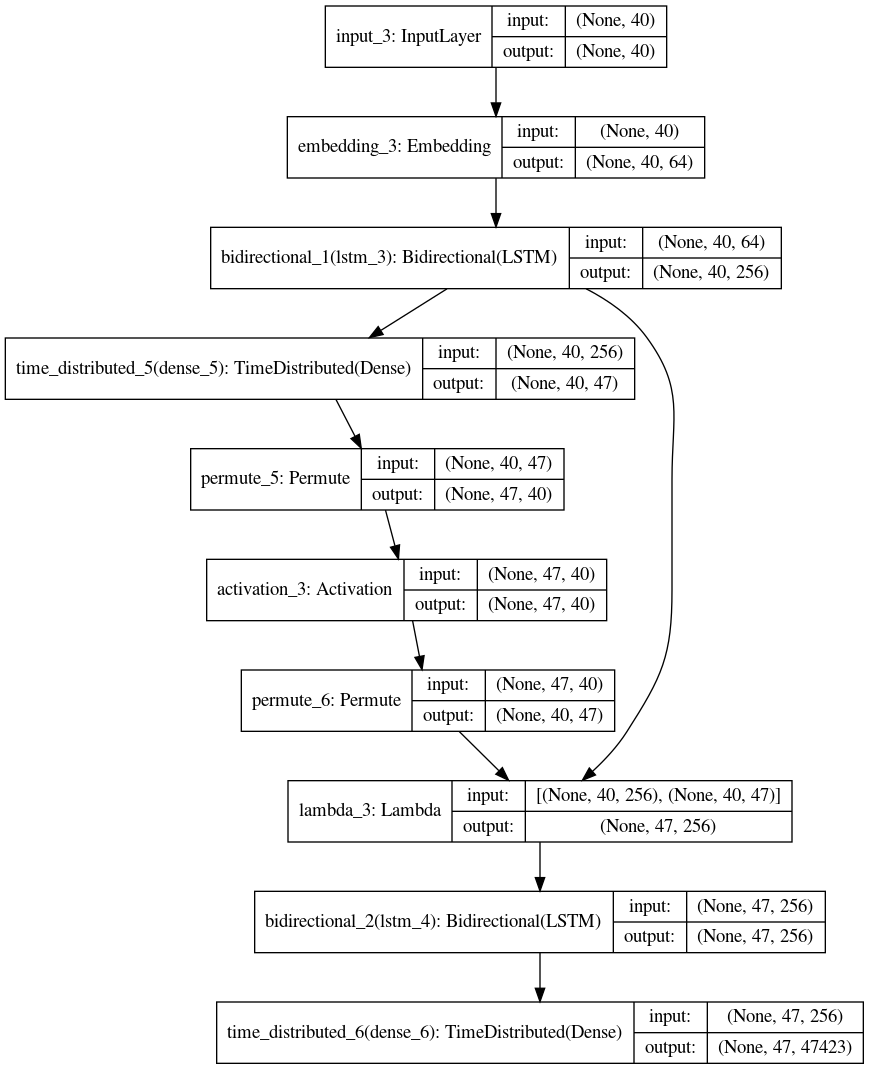

In [34]:
plot_model(model, to_file='model_p2.png', show_shapes=True)
Image(filename='model_p2.png')

In [30]:
model.fit(Xtrain_question,X_answers,epochs=10,batch_size=128,validation_split=0.2)

Train on 69456 samples, validate on 17365 samples
Epoch 1/10
69456/69456 [==============================] - 599s 9ms/step - loss: 1.0957 - val_loss: 0.8033
Epoch 2/10
69456/69456 [==============================] - 596s 9ms/step - loss: 0.7034 - val_loss: 0.8042
Epoch 3/10
69456/69456 [==============================] - 596s 9ms/step - loss: 0.6868 - val_loss: 0.8124
Epoch 4/10
69456/69456 [==============================] - 595s 9ms/step - loss: 0.6751 - val_loss: 0.8191
Epoch 5/10
69456/69456 [==============================] - 593s 9ms/step - loss: 0.6665 - val_loss: 0.8231
Epoch 6/10
69456/69456 [==============================] - 590s 8ms/step - loss: 0.6576 - val_loss: 0.8303
Epoch 7/10
69456/69456 [==============================] - 594s 9ms/step - loss: 0.6497 - val_loss: 0.8347
Epoch 8/10
69456/69456 [==============================] - 594s 9ms/step - loss: 0.6423 - val_loss: 0.8362
Epoch 9/10
69456/69456 [==============================] - 594s 9ms/step - loss: 0.6359 - val_loss: 0.8

In [0]:
model.save("drive/QA-BILSTM.h5")

In [0]:
from keras.models import load_model
model = load_model('drive/QA-BILSTM.h5')

In [31]:
n = 10
for i in range(n):
    indexs = np.random.randint(0,len(Xtest_question))
    example = Xtest_question[indexs]
    indexes_answer = predict_words(model,example,20)
    question = df_test["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index] == "#end": # el final de la oracion
            continue
        else:
            answer += indices_vocabA[index]+" "
    print("Respuesta: ", answer)
print("Los ha predecido todos!")

Pregunta:  Where did the pharmacist stand in relation to the Emperor's personal physicians?
Respuesta:  108-A solo Galaxy refer £240m Episcopalians 1,845 Hangzhou Chao Episcopalians 1780–81 refer 64Zn policies gastrointestinal Hangzhou Tigrinya Orlando Orlando gastrointestinal refer Lydia policies Hua pin refer Hangzhou Lydia Hangzhou Hangzhou Borman Situ pin Galaxy Liangzhu Galaxy £240m £240m Liangzhu 1,845 Situ Recycles refer 
Pregunta:  What river separates Jacksonville?
Respuesta:  Specialist silverfish Moçâmedes Nyima dimensional 1,845 1,845 Galaxy summit Galaxy ex-colonial Recycles Bargate Situ Nyima dimensional summit £240m Galaxy Nyima Nyima 1780–81 Lieutenant-General Nyima Hua Pirates pin 64Zn gastrointestinal gastrointestinal pin Liangzhu 1780–81 1780–81 Galaxy motu Nyima 1780–81 Recycles refer motu Galaxy Tigrinya motu Hua Tigrinya 
Pregunta:  What is defined as the majority vote?
Respuesta:  ex-colonial policies eavesdropping fourfold Tigrinya reader fourfold Chao summit £2

Para este caso se aumenta la diversidad y se encuentran respuestas con menos números. Además, sorprende que muchas palabras tienen mayúscula en su primera letra, lo que dice que son nombres o son palabras que se encontraban en el primer lugar en las oraciones de entrenamiento.

In [32]:
#import json
contador = 1
dic_predictions = {}
for example,id_e in zip(Xtest_question,df_test["id"]): #todos los ejemplos
    indexes_answer = predict_words(model,example,10) #predice palabra en cada instante
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    dic_predictions[id_e] = answer
    contador+=1
print("Los ha predecido todos!")
json_save = json.dumps(dic_predictions)
archivo = open("predictions","w")
archivo.write(json_save)
archivo.close()

Los ha predecido todos!


In [38]:
#evaluar resultados
#!wget https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
#!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
!python drive/Colab-Notebooks/evaluate-v2.0.py dev-v2.0.json predictions
#!ls

{
  "exact": 0.0,
  "f1": 0.0015385362369163935,
  "total": 11873,
  "HasAns_exact": 0.0,
  "HasAns_f1": 0.0030814846054163865,
  "HasAns_total": 5928,
  "NoAns_exact": 0.0,
  "NoAns_f1": 0.0,
  "NoAns_total": 5945
}


In [ ]:
Para esta compuerta el resultado de f1 vuelve a bajar a las centenas.

Como trabajo a futuro, se propone trabajar con fuentes de conocimiento, como la misma wikipedia p